In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

In [ ]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
tf.config.list_physical_devices('GPU')


Num GPUs Available:  1


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar100.load_data()

x = np.concatenate((x_train, x_test), axis=0)
y = np.concatenate((y_train, y_test), axis=0)
# y = tf.keras.utils.to_categorical(y,num_classes = 100)

169001437/169001437 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [ ]:
#base and novel
base_classes = list(range(60))
novel_classes = list(range(70, 100))
probe_classes = list(range(60,70))

def split_dataset(x, y, base=True):
    if base == True:
        classes = base_classes
    else:
        classes = novel_classes
    mask = np.isin(y, classes).flatten()
    return x[mask], y[mask]
def split_dataset_2(x, y, base=True):
    if base == True:
        classes = base_classes
    else:
        classes = probe_classes
    mask = np.isin(y, classes).flatten()
    return x[mask], y[mask]

x_base, y_base = split_dataset(x, y, base=True)
x_probe,y_probe = split_dataset_2(x_base,y_base,base=False)
x_novel, y_novel = split_dataset(x, y, base=False)



In [ ]:
def preprocess(image, label):
    image = tf.image.resize(image, [224, 224])  # smaller resize
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

base_ds = tf.data.Dataset.from_tensor_slices((x_base, y_base))
base_ds = base_ds.map(preprocess).batch(32).prefetch(tf.data.AUTOTUNE)

novel_ds = tf.data.Dataset.from_tensor_slices((x_novel, y_novel))
novel_ds = novel_ds.map(preprocess).batch(32).prefetch(tf.data.AUTOTUNE)

probe_ds = tf.data.Dataset.from_tensor_slices((x_probe, y_probe))
probe_ds = probe_ds.map(preprocess).batch(32).prefetch(tf.data.AUTOTUNE)


In [ ]:
'''
Get the cifar100 data
split it into train and test
split the train into base and novel
split the base into probe and not probe
split the probe into anchor and validation

Residual Network ResNet trained for 224x224 size , cifar100 32x32x3 size , so dimentioon reduce so fast high level features not captured
pretrained weights solve this problem but still we need to resize it

then add another dense layer and unfreeze some layer then fine tune this layers on our labelled dataset


fine tuning the feature extractor resnet on labelled data : This means unfreeze some layers and train them on what ? how does it work ?

'''


'\nGet the cifar100 data\nsplit it into train and test\nsplit the train into base and novel\nsplit the base into probe and not probe\nsplit the probe into anchor and validation\n\nResidual Network ResNet trained for 224x224 size , cifar100 32x32x3 size , so dimentioon reduce so fast high level features not captured\npretrained weights solve this problem but still we need to resize it\n\nthen add another dense layer and unfreeze some layer then fine tune this layers on our labelled dataset\n\n\nfine tuning the feature extractor resnet on labelled data : This means unfreeze some layers and train them on what ? how does it work ?\n\n'

In [ ]:
base_layer = tf.keras.applications.ResNet50(
    weights = "imagenet",
    include_top = False,
    input_shape = (224,224,3)
)

for layer in base_layer.layers:
    layer.trainable = False

for layer in base_layer.layers:
    if "conv5_block" in layer.name:
        layer.trainable = True


model = tf.keras.Sequential([
    base_layer,
    tf.keras.layers.GlobalAveragePooling2D(),  # ← Fixed typo here
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(60, activation='softmax')
])


model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.fit(base_ds, epochs=10)



94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 153s 115ms/step - accuracy: 0.0636 - loss: 3.8658
Epoch 2/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 131s 116ms/step - accuracy: 0.1933 - loss: 3.1495
Epoch 3/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 142s 116ms/step - accuracy: 0.2452 - loss: 2.8854
Epoch 4/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 130s 116ms/step - accuracy: 0.2833 - loss: 2.7204
Epoch 5/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 142s 116ms/step - accuracy: 0.3147 - loss: 2.5948
Epoch 6/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 142s 116ms/step - accuracy: 0.3412 - loss: 2.4847
Epoch 7/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 142s 116ms/step - accuracy: 0.3593 - loss: 2.3864
Epoch 8/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 130s 116ms/step - accuracy: 0.3845 - loss: 2.2910
Epoch 9/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 142s 116ms/step - accuracy: 0.4056 - loss: 2.1992
Epoch 10/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 131s 116ms/step - accuracy: 0.4257 - loss: 2.1079


In [ ]:
# Create a new model up to the GlobalAveragePooling2D layer
feature_extractor = tf.keras.Sequential(model.layers[:2])  # Keep only base_layer and GAP

In [ ]:
#feature extraction of unlabelled data done
features = feature_extractor.predict(novel_ds)

563/563 ━━━━━━━━━━━━━━━━━━━━ 54s 88ms/step


In [ ]:
print(features.shape)

(18000, 2048)


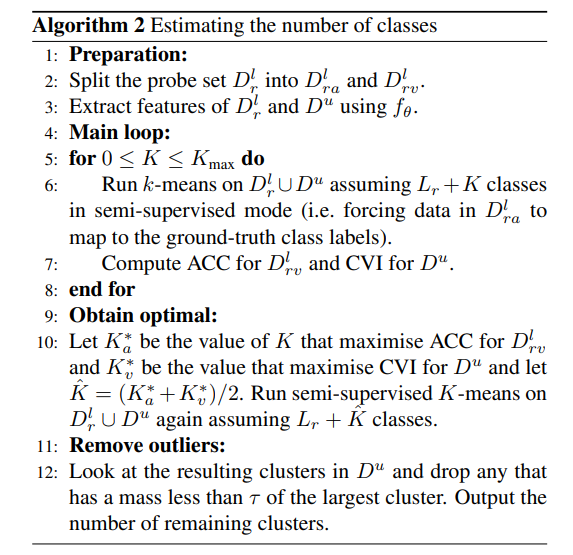

## K_est comes from above algorithm , it generally gives more number that actual but more is better than less as mentioned in the paper as ACC and NMI decrease faster with lesser clusters than larger

In [ ]:
from sklearn.decomposition import PCA
K_est = 30  # Number of estimated clusters

# Apply PCA directly to the feature matrix
pca = PCA(n_components=K_est)
reduced_features = pca.fit_transform(features)  # shape will be (18000, 30)

print(reduced_features.shape)  # should print (18000, 30)

(18000, 30)


In [ ]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# Assume reduced_features has shape (18000, 30)
num_clusters = 30

# Initialize and fit KMeans
kmeans = KMeans(n_clusters=num_clusters, init='k-means++', random_state=42, n_init=10) # Added n_init for robustness
cluster_assignments = kmeans.fit_predict(reduced_features)

# The final learned cluster centers are available after fitting
final_centroids = kmeans.cluster_centers_

# Print shape
print("Cluster assignments shape:", cluster_assignments.shape)   # (18000,)
print("Final centroids shape:", final_centroids.shape)           # (30, 30)

Cluster assignments shape: (18000,)
Final centroids shape: (30, 30)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


In [ ]:
class Args:
    def __init__(self):
        self.lr = 0.05               # learning rate
        self.warmup_lr = 0.1         #lr for warmup training
        self.batch_size = 32          # batch size
        self.warmup_epochs = 10       # number of warm-up epochs
        self.n_clusters = 30          # number of clusters
        self.model_dir = '/content/drive/MyDrive/dtc_model/model.ckpt'  # where to save model weights
        self.n_train = 18000          # total training samples

# Usage:
args = Args()


In [ ]:

def feat2prob(feat, center, alpha=1.0):
    # feat: (batch_size, feature_dim)
    # center: (num_clusters, feature_dim)

    # Expand feat to (batch_size, 1, feature_dim) for broadcasting
    feat_expanded = tf.expand_dims(feat, axis=1)  # shape: (B, 1, D)

    # Compute squared Euclidean distance between feat and center
    dist_sq = tf.reduce_sum(tf.square(feat_expanded - center), axis=2)  # (B, K)

    q = 1.0 / (1.0 + dist_sq / alpha)  # (B, K)
    q = tf.pow(q, (alpha + 1.0) / 2.0)  # (B, K)

    # Normalize across clusters (columns) for each sample
    q = tf.transpose(q) / tf.reduce_sum(q, axis=1)
    q = tf.transpose(q)  # final shape: (B, K)

    return q


def target_distribution(q):
    # q: (batch_size, num_clusters)

    weight = tf.square(q) / tf.reduce_sum(q, axis=0)  # shape: (B, K)
    p = tf.transpose(weight) / tf.reduce_sum(weight, axis=1)
    p = tf.transpose(p)  # final shape: (B, K)

    return p

In [ ]:
def kl_divergence(p_log, q):
    return tf.reduce_mean(tf.reduce_sum(q * tf.math.log((q + 1e-10) / (p + 1e-10)), axis=1))

# Forward pass
p = feat2prob(reduced_features, final_centroids)
q = target_distribution(p)

# KL divergence loss: KL(q || p)
loss = kl_divergence(p,q)
print(loss)

In [ ]:
class AverageMeter:
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0.0
        self.sum = 0.0
        self.count = 0
        self.avg = 0.0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

### WARM UP TRAINING

In Warm-Up Training Algorithm we first calculate target distribution directly from the predictions using initial f(titha) and U

In [ ]:
def warmup_training(model, train_ds, center, args):
    optimizer = tf.keras.optimizers.Adam(learning_rate=args.lr)

    print("=== Starting Warm-Up Phase ===")

    # Step 1: Compute initial soft assignments (p) and fixed targets (q)
    all_features = []

    for x_batch, y_batch in base_ds.take(1):
      print(x_batch.shape)  # should be (batch_size, 224, 224, 3)


    for x_batch, _ in train_ds:
        features = model(x_batch, training=False)
        all_features.append(features)

    all_features = tf.concat(all_features, axis=0)  # shape (N, D)
    p_all = feat2prob(all_features, center)         # shape (N, K)
    q_all = target_distribution(p_all)              # shape (N, K) — this is fixed target

    # For simplicity: assume train_ds is ordered to match q_all
    # Otherwise, you must track sample indices and map q_all back to batches

    q_iter = iter(tf.data.Dataset.from_tensor_slices(q_all).batch(args.batch_size))

    # Step 2: Warm-up training
    for epoch in range(args.warmup_epochs):
        loss_meter = AverageMeter()

        for (x_batch, _), q_batch in zip(train_ds, q_iter):
            with tf.GradientTape() as tape:
                features = model(x_batch, training=True)
                p = feat2prob(features, center)  # current soft assignment

                # KL divergence: KL(q || p)
                loss = tf.reduce_mean(tf.reduce_sum(q_batch * tf.math.log((q_batch + 1e-10) / (p + 1e-10)), axis=1))

            grads = tape.gradient(loss, model.trainable_variables + [center])
            optimizer.apply_gradients(zip(grads, model.trainable_variables + [center]))
            loss_meter.update(loss.numpy(), x_batch.shape[0])

        print(f"Warm-Up Epoch {epoch:02d} — Avg Loss: {loss_meter.avg:.4f}")

    print("=== Warm-Up Phase Complete ===")
    model.save_weights(args.model_dir)
    print(f"Model weights saved to: {args.model_dir}")
    return model, center

feature_extractor,centre = warmup_training(feature_extractor, base_ds, final_centroids, args)


In [ ]:

def train_cluster_model(model, dataset, center, args):
    optimizer = tf.keras.optimizers.Adam(learning_rate=args.lr)

    for epoch in range(args.epochs):
        loss_meter = AverageMeter()

        for step, (x_batch, _) in enumerate(dataset):
            with tf.GradientTape() as tape:
                features = model(x_batch, training=True)  # (B, D)

                q = feat2prob(features, center)  # (B, K)
                p = target_distribution(q)       # (B, K)

                # KL divergence loss: KL(p || q)
                loss = tf.reduce_mean(tf.reduce_sum(p * tf.math.log((p + 1e-10) / (q + 1e-10)), axis=1))

            # Compute gradients and apply update to model + cluster centers
            variables = model.trainable_variables + [center]
            grads = tape.gradient(loss, variables)
            optimizer.apply_gradients(zip(grads, variables))

            loss_meter.update(loss.numpy(), x_batch.shape[0])

        print(f"Epoch {epoch:02d}: Avg Loss = {loss_meter.avg:.4f}")


In [ ]:
def main_training(model, train_ds, center, args):
    optimizer = tf.keras.optimizers.Adam(learning_rate=args.warmup_lr)

    N = args.n_train
    q_all = tf.zeros((N, args.n_clusters), dtype=tf.float32)  # updated every epoch

    print("=== Starting Main Clustering Phase ===")

    for epoch in range(args.train_epochs):
        loss_meter = AverageMeter()

        # Step 1: Compute current soft assignments for all samples
        features_all = []
        indices_all = []
        for x_batch, _, idx_batch in train_ds:
            feat = model(x_batch, training=False)
            features_all.append(feat)
            indices_all.append(idx_batch)

        features_all = tf.concat(features_all, axis=0)               # shape: (N, D)
        indices_all = tf.concat(indices_all, axis=0)                 # shape: (N,)
        p_all = feat2prob(features_all, center)                      # shape: (N, K)
        q_all = target_distribution(p_all)                           # shape: (N, K)

        # Step 2: Iterate through batches for training
        q_all_ds = tf.data.Dataset.from_tensor_slices(q_all)
        q_all_ds = q_all_ds.batch(args.batch_size)
        q_iter = iter(q_all_ds)

        for (x_batch, _, idx_batch), q_batch in zip(train_ds, q_iter):
            with tf.GradientTape() as tape:
                feat = model(x_batch, training=True)
                p = feat2prob(feat, center)

                # KL(q || p): sharpened q is the target
                loss = tf.reduce_mean(tf.reduce_sum(q_batch * tf.math.log((q_batch + 1e-10) / (p + 1e-10)), axis=1))

            grads = tape.gradient(loss, model.trainable_variables + [center])
            optimizer.apply_gradients(zip(grads, model.trainable_variables + [center]))
            loss_meter.update(loss.numpy(), x_batch.shape[0])

        print(f"Train Epoch {epoch:02d} — Avg Loss: {loss_meter.avg:.4f}")

    print("=== Main Training Complete ===")
    model.save_weights(args.model_dir)
    print(f"Model saved to {args.model_dir}")
    return model,centre


In [ ]:
import numpy as np
from sklearn.metrics import normalized_mutual_info_score
from scipy.optimize import linear_sum_assignment

def clustering_accuracy(y_true, y_pred):
    """
    Clustering accuracy with Hungarian matching.
    y_true: true labels, shape (N,)
    y_pred: predicted cluster indices, shape (N,)
    """
    y_true = np.array(y_true, dtype=np.int64)
    y_pred = np.array(y_pred, dtype=np.int64)

    assert y_pred.size == y_true.size
    D = max(y_pred.max(), y_true.max()) + 1
    confusion_matrix = np.zeros((D, D), dtype=np.int64)

    for i in range(y_pred.size):
        confusion_matrix[y_pred[i], y_true[i]] += 1

    row_ind, col_ind = linear_sum_assignment(confusion_matrix.max() - confusion_matrix)
    accuracy = confusion_matrix[row_ind, col_ind].sum() / y_pred.size
    return accuracy

def evaluate_clustering(features, centers, true_labels):
    """
    Evaluate clustering performance (ACC, NMI).
    features: shape (N, D)
    centers: shape (K, D)
    true_labels: shape (N,)
    """
    # Step 1: Assign each point to nearest cluster center (soft)
    feat_tensor = tf.convert_to_tensor(features, dtype=tf.float32)
    center_tensor = tf.convert_to_tensor(centers, dtype=tf.float32)

    p = feat2prob(feat_tensor, center_tensor)  # shape: (N, K)
    pred_labels = tf.argmax(p, axis=1).numpy()

    # Step 2: ACC
    acc = clustering_accuracy(true_labels, pred_labels)

    # Step 3: NMI
    nmi = normalized_mutual_info_score(true_labels, pred_labels)

    print(f"Clustering Accuracy (ACC): {acc * 100:.2f}%")
    print(f"Normalized Mutual Information (NMI): {nmi:.4f}")

    return acc, nmi
